# Treatment of Real Images

In [1]:
from pathlib import Path
import imageio.v2 as imageio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [5]:
images_dir = Path("../Real-Images")  # change to your folder path if needed
files = sorted(images_dir.glob("*.tif"))
arr = imageio.imread(files[0])

In [6]:
arr.shape

(2052, 2560, 4)

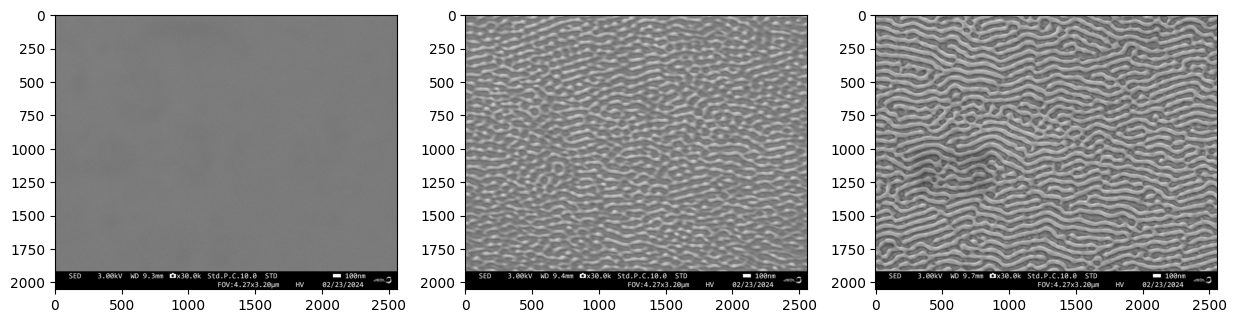

In [8]:
# Plot the 1st 25th and 50th image

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for number in ['1', '25', '50']:

    path = Path(f"../Real-Images/{number}.tif")
    arr = imageio.imread(path)

    axes[int(number) // 25].imshow(arr[: , :, 0], cmap='gray')
    #plt.imshow(arr[: , :, 0], cmap='gray')

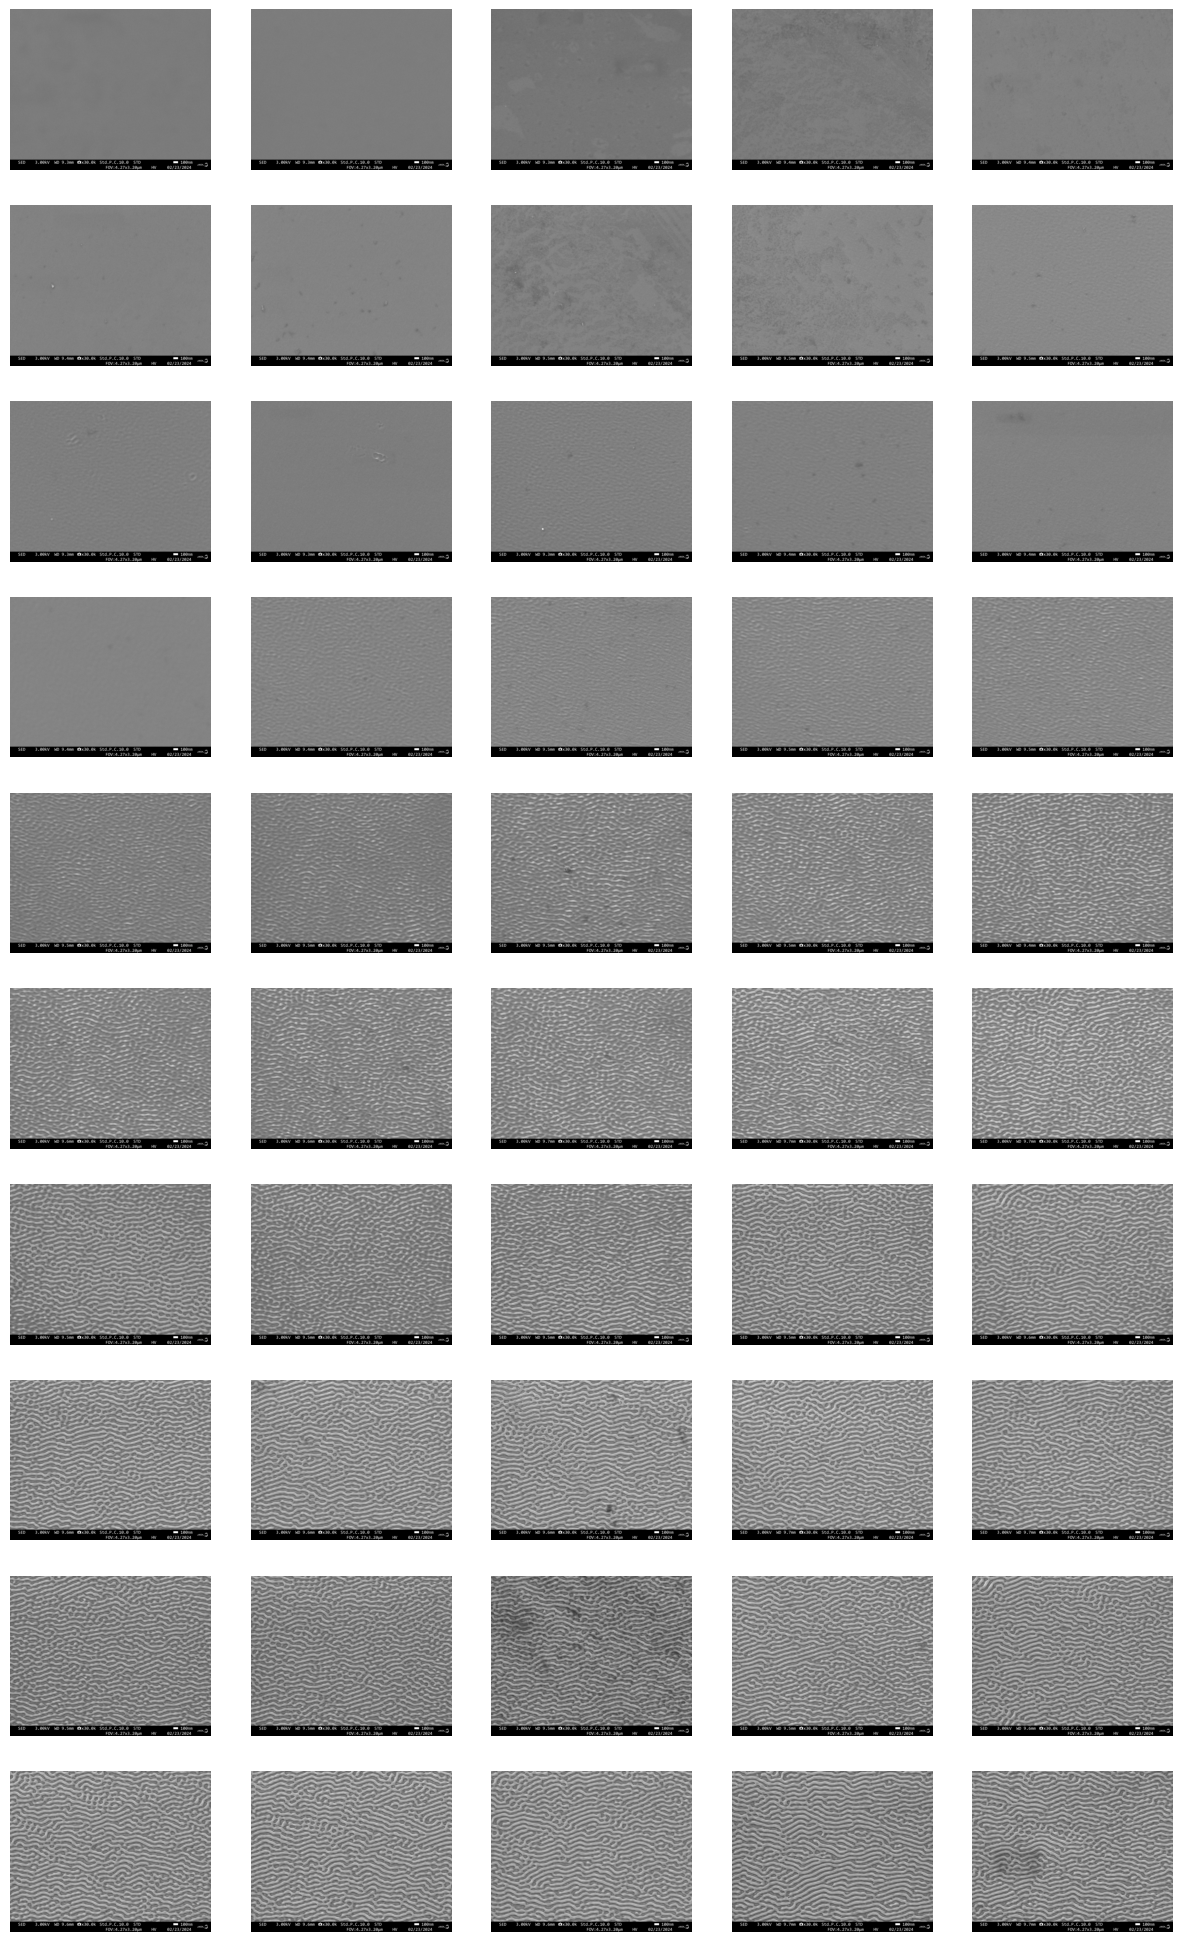

In [18]:
# PLot all 50 frames

fig, axes = plt.subplots(10, 5, figsize=(15, 25))

for number in [i for i in range(50)]:

    path = Path(f"../Real-Images/{number+1}.tif")
    arr = imageio.imread(path)

    r, c = divmod(number, 5)
    ax = axes[r, c]
    # show RGB (drop alpha) or grayscale as appropriate
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        ax.imshow(arr[..., :3])
    else:
        ax.imshow(arr, cmap='gray')
    ax.axis('off')
    #plt.imshow(arr[: , :, 0], cmap='gray')

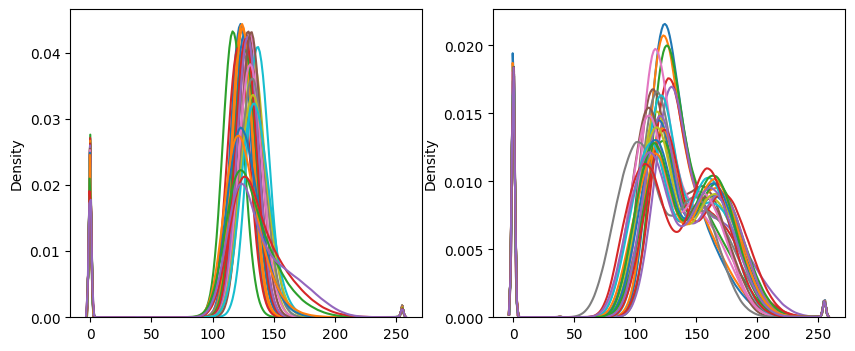

In [21]:
# Check the color distribution for these in one single kde plot
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for number in [i for i in range(50)]:

    path = Path(f"../Real-Images/{number+1}.tif")
    arr = imageio.imread(path)[:, :, 0]
    pixels = arr.ravel().astype(float)
    
    if number < 25:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[0])
    else:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[1])

plt.show()


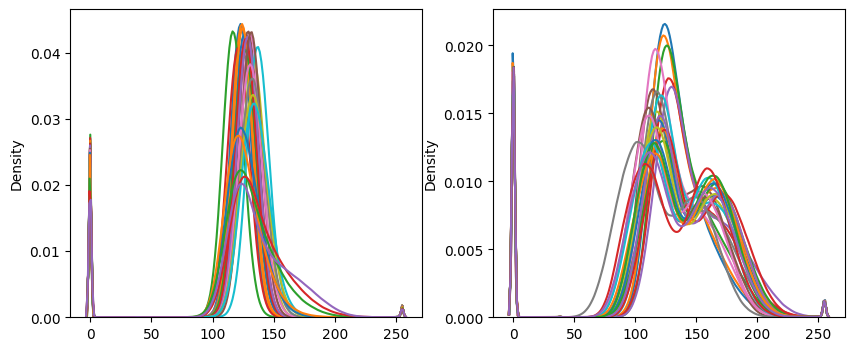

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for number in [i for i in range(50)]:

    path = Path(f"../Real-Images/{number+1}.tif")
    arr = imageio.imread(path)[:, :, 1]
    pixels = arr.ravel().astype(float)
    
    if number < 25:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[0])
    else:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[1])

plt.show()

In [25]:
# ...existing code...
def normalize_minmax_per_image(arr):
    """Scale image (H,W) or (H,W,3) to 0..1 per-image (per-channel for color)."""
    a = arr.astype(np.float32)
    if a.ndim == 3:
        ch_min = a.reshape(-1, a.shape[2]).min(axis=0)
        ch_max = a.reshape(-1, a.shape[2]).max(axis=0)
        denom = ch_max - ch_min
        denom[denom == 0] = 1.0
        return ((a - ch_min) / denom).astype(np.float32)
    else:
        amin, amax = a.min(), a.max()
        return np.zeros_like(a, dtype=np.float32) if amax == amin else ((a - amin) / (amax - amin)).astype(np.float32)

def normalize_minmax_across_dataset(files):
    """Compute per-channel global min/max and return list of normalized images (0..1)."""
    mins = np.full(3, np.inf, dtype=np.float32)
    maxs = np.full(3, -np.inf, dtype=np.float32)
    for fp in files:
        arr = imageio.imread(fp)[:,:,0].astype(np.float32)
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=-1)
        ch_min = arr.reshape(-1, arr.shape[2]).min(axis=0)
        ch_max = arr.reshape(-1, arr.shape[2]).max(axis=0)
        mins = np.minimum(mins, ch_min)
        maxs = np.maximum(maxs, ch_max)
    denom = maxs - mins
    denom[denom == 0] = 1.0
    out = []
    for fp in files:
        arr = imageio.imread(fp).astype(np.float32)
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=-1)
        arr = (arr - mins) / denom
        out.append(np.clip(arr, 0.0, 1.0))
    return out

# Usage examples (you said you know dims/files):
# per-image normalize:
# img_norm = normalize_minmax_per_image(arr)         # arr -> values in [0,1]
# dataset normalize:
# imgs_norm = normalize_minmax_across_dataset(files) # list of images in [0,1]
# For KDE (single-channel array `img_norm`): pixels = img_norm.ravel()  # use as-is or *255
# ...existing code...

In [27]:
imgs_norm = normalize_minmax_across_dataset(files)

ValueError: operands could not be broadcast together with shapes (2052,2560,4) (3,) 